#Retinal Blood vessel segmentation by  CNN

# Setting up the drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Loading and preparing data

In [0]:
import os
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

In [0]:
data_path = '/content/gdrive/My Drive/Retinal/training/'

image_width = 565
image_height = 584

In [0]:
img_data_path = os.path.join(data_path, 'images')
seg_data_path = os.path.join(data_path, '1st_manual')

print(img_data_path)
print(seg_data_path)

images = sorted(os.listdir(img_data_path))
segs = sorted(os.listdir(seg_data_path))
num_images = len(images)
num_segs = len(segs)
print('number of images:',num_images , num_segs)

/content/gdrive/My Drive/Retinal/training/images
/content/gdrive/My Drive/Retinal/training/1st_manual
number of images: 20 20


In [0]:
imgs_array = np.ndarray((num_images, image_width, image_height), dtype=np.uint8)
segs_array = np.ndarray((num_segs, image_width, image_height), dtype=np.uint8)

In [0]:
print('Creating training images arrays...')
n = 0
good_imgs=[]
for image_name in images:
    #print('reading image %s    %d' % (image_name,n+1))
    img = Image.open(os.path.join(img_data_path,image_name)).convert('L') 
    good_imgs.append(image_name)
    img = np.array(img.resize((image_height,image_width)))
    imgs_array[n] = img
    n +=1

np.save('/content/gdrive/My Drive/Retinal/training/imgs_train.npy', imgs_array[0:len(good_imgs)])
print(len(good_imgs),imgs_array.shape)


n = 0
good_imgs=[]
for image_name in segs:
    #print('reading seg %s    %d' % (image_name,n+1))
    img = Image.open(os.path.join(seg_data_path,image_name)).convert('L')
    good_imgs.append(image_name)
    img = np.array(img.resize((image_height,image_width)))
    segs_array[n] = img
    n +=1
  
np.save('/content/gdrive/My Drive/Retinal/training/seg_train.npy', segs_array[0:len(good_imgs)])
print('finished saving image arrays.')

print(segs_array.shape)

Creating training images arrays...
20 (20, 565, 584)
finished saving image arrays.
(20, 565, 584)


In [0]:
imgs_array[0:len(good_imgs)].shape

(20, 565, 584)

In [0]:
'''
img_no=10
print(imgs_array.shape)
w=Image.fromarray(imgs_array[img_no].reshape(image_width,image_height))
display(w)

print(imgs_array.shape)
w=Image.fromarray(segs_array[img_no].reshape(image_width,image_height))
display(w)
'''

'\nimg_no=10\nprint(imgs_array.shape)\nw=Image.fromarray(imgs_array[img_no].reshape(image_width,image_height))\ndisplay(w)\n\nprint(imgs_array.shape)\nw=Image.fromarray(segs_array[img_no].reshape(image_width,image_height))\ndisplay(w)\n'

In [0]:
del imgs_array
del segs_array

In [0]:
#making patches of size 128*128
patch_size=128
step_size=16
imgs = np.load(data_path+'imgs_train.npy')
segs = np.load(data_path+'seg_train.npy')

from skimage.util.shape import view_as_windows

imgs_patches = np.array([])
segs_patches = np.array([])
for i in range(imgs.shape[0]):
  patches=view_as_windows(imgs[i], (patch_size, patch_size), step=step_size)
  patches=patches.reshape(-1,patch_size,patch_size)
  seg_pats=view_as_windows(segs[i], (patch_size, patch_size), step=step_size)
  seg_pats=seg_pats.reshape(-1,patch_size,patch_size)
 
  if i==0:
    imgs_patches=patches
    segs_patches=seg_pats
  else:
    imgs_patches=np.append(imgs_patches,patches,axis=0)
    segs_patches=np.append(segs_patches,seg_pats,axis=0)


In [0]:
patches.shape, imgs_patches.shape, segs_patches.shape

((812, 128, 128), (16240, 128, 128), (16240, 128, 128))

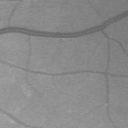

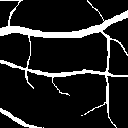

In [0]:
w=Image.fromarray(imgs_patches[190].reshape(patch_size,patch_size))
display(w)
w=Image.fromarray(segs_patches[190].reshape(patch_size,patch_size))
display(w)

# Training

In [0]:
from __future__ import print_function
import os
from PIL import Image
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, \
                          Flatten, Dense, UpSampling2D,Dropout,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split 

In [0]:

imgs_patches = imgs_patches[:,:,:,np.newaxis]
segs_patches = segs_patches[:,:,:,np.newaxis]

imgs_patches = imgs_patches.astype('float32')
imgs_patches /=255.0
segs_patches = segs_patches.astype('float32')
segs_patches /=255.0

#segs_patches=to_categorical(segs_patches, num_classes=2)
segs_patches.shape

(16240, 128, 128, 1)

In [0]:
imgs_patches.shape

(16240, 128, 128, 1)

In [0]:
train_imgs, valid_imgs, train_segs, valid_segs = \
                    train_test_split(imgs_patches, segs_patches, test_size=0.2, random_state=54)

del imgs_patches
del segs_patches
import gc
gc.collect()

10

In [0]:
from numpy.random import seed
seedval=29
seed(seedval*1)
from tensorflow import set_random_seed
set_random_seed(seedval*2)

Model architecture

In [0]:
def BN_ReLU(input_features): 
    output_features = BatchNormalization()(input_features)
    output_features = Activation('relu')(output_features)
    return output_features


def Model_Architecture(input_layer):
    initial_num_filters=16
    input_layer = BatchNormalization()(input_layer)  #sdg 
    #in:128--out:64
    conv1 = Conv2D(initial_num_filters * 1, (3, 3), padding="same")(input_layer)
    out = BN_ReLU(conv1) 
    out = MaxPooling2D((2, 2))(out)   #check stride? sdg
    out = Dropout(0.2)(out)
    #in:64--out:32
    conv2 = Conv2D(initial_num_filters * 2, (3, 3), padding="same")(out)
    out = BN_ReLU(conv2) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:32--out:16
    conv3 = Conv2D(initial_num_filters * 3, (3, 3), padding="same")(out)
    out = BN_ReLU(conv3) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:16--out:8
    conv4 = Conv2D(initial_num_filters * 4, (3, 3), padding="same")(out)
    out = BN_ReLU(conv4) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:8--out:4
    conv5 = Conv2D(initial_num_filters * 5, (3, 3), padding="same")(out)
    out = BN_ReLU(conv5) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:4--out:2
    conv6 = Conv2D(initial_num_filters * 6, (3, 3), padding="same")(out)
    out = BN_ReLU(conv6) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:2--out:1
    conv7 = Conv2D(initial_num_filters * 7, (3, 3), padding="same")(out)
    out = BN_ReLU(conv7) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    

    #Decoding
    convT7 = Conv2DTranspose(initial_num_filters * 7, (3, 3), strides=(2, 2), padding="same")(out)
    convT7 = Conv2D(initial_num_filters * 7, (3, 3), padding="same")(convT7)
    out = concatenate([convT7, conv7])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT6 = Conv2DTranspose(initial_num_filters * 6, (3, 3), strides=(2, 2), padding="same")(out)
    convT6 = Conv2D(initial_num_filters * 6, (3, 3), padding="same")(convT6)
    out = concatenate([convT6, conv6])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    
    convT5 = Conv2DTranspose(initial_num_filters * 5, (3, 3), strides=(2, 2), padding="same")(out)
    convT5 = Conv2D(initial_num_filters * 5, (3, 3), padding="same")(convT5)
    out = concatenate([convT5, conv5])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)

    
    convT4 = Conv2DTranspose(initial_num_filters * 4, (3, 3), strides=(2, 2), padding="same")(out)
    convT4 = Conv2D(initial_num_filters * 4, (3, 3), padding="same")(convT4)
    out = concatenate([convT4, conv4])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    
    convT3 = Conv2DTranspose(initial_num_filters * 3, (3, 3), strides=(2, 2), padding="same")(out)
    convT3 = Conv2D(initial_num_filters * 3, (3, 3), padding="same")(convT3)
    out = concatenate([convT3, conv3])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT2 = Conv2DTranspose(initial_num_filters * 2, (3, 3), strides=(2, 2), padding="same")(out)
    convT2 = Conv2D(initial_num_filters * 2, (3, 3), padding="same")(convT2)
    out = concatenate([convT2, conv2])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT1 = Conv2DTranspose(initial_num_filters * 1, (3, 3), strides=(2, 2), padding="same")(out)
    convT1 = Conv2D(initial_num_filters * 1, (3, 3), padding="same")(convT1)
    out = concatenate([convT1, conv1])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(out)
    return output_layer

  
input_layer=Input(shape=(128,128,1))
output_layer=Model_Architecture(input_layer)

model=Model(inputs=input_layer,outputs=output_layer)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [0]:
import tensorflow as tf
def focal_loss(gamma=2., alpha=.60):
    def focal_loss_fixed(y_true, y_pred):
        pt1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        # clip to prevent NaN's and Inf's
        pt1 = K.clip(pt1, K.epsilon(), 1-K.epsilon())
        pt0 = K.clip(pt0, K.epsilon(), 1-K.epsilon())
        return -K.mean(alpha * K.pow(1. - pt1, gamma) * K.log(pt1), axis=-1) \
               -K.mean((1-alpha) * K.pow( pt0, gamma) * K.log(1. - pt0) ,axis=-1)
    return focal_loss_fixed
 
#loss =[focal_loss(gamma=0.0,alpha=0.60)], 'categorical_crossentropy'

In [0]:
model.compile(optimizer=Adam(lr=0.001), loss = [focal_loss(gamma=0.1,alpha=0.60)] , metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model_checkpoint = ModelCheckpoint(data_path+"checkpoint/keras.model", monitor='val_loss', save_best_only=True, verbose=1)

In [0]:
batchsize=64
# we create two instances with the same arguments
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = seedval*4


image_generator = image_datagen.flow(train_imgs, batch_size=batchsize, shuffle=True, seed=seed)
mask_generator = mask_datagen.flow(train_segs, batch_size=batchsize, shuffle=True, seed=seed)


# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(len(train_imgs)/batchsize),
    validation_data = (valid_imgs, valid_segs),
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    initial_epoch=0,
    epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
203/203 [==============================] - 79s 389ms/step - loss: 0.1284 - acc: 0.8932 - val_loss: 0.0873 - val_acc: 0.9373

Epoch 00001: val_loss improved from inf to 0.08725, saving model to /content/gdrive/My Drive/Retinal/training/checkpoint/keras.model
Epoch 2/100
203/203 [==============================] - 70s 345ms/step - loss: 0.0781 - acc: 0.9409 - val_loss: 0.0725 - val_acc: 0.9478

Epoch 00002: val_loss improved from 0.08725 to 0.07254, saving model to /content/gdrive/My Drive/Retinal/training/checkpoint/keras.model
Epoch 3/100
203/203 [==============================] - 70s 345ms/step - loss: 0.0703 - acc: 0.9452 - val_loss: 0.0659 - val_acc: 0.9509

Epoch 00003: val_loss improved from 0.07254 to 0.06594, saving model to /content/gdrive/My Drive/Retinal/training/checkpoint/keras.model
Epoch 4/100
203/203 [==============================] - 70s 345ms/step - loss: 0.0667 - acc: 0.9473 - val_loss: 0.0603 - val_acc: 0.953

In [0]:
'''
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="Training loss")
plt.plot(model_history.history["val_loss"], label="Validation loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="*", color="y", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
'''

'\nplt.figure(figsize=(8, 8))\nplt.title("Learning curve")\nplt.plot(model_history.history["loss"], label="Training loss")\nplt.plot(model_history.history["val_loss"], label="Validation loss")\nplt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="*", color="y", label="Best model")\nplt.xlabel("Epochs")\nplt.ylabel("Loss")\nplt.legend();\n'